In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from utils import *

_u = 1e6
_G = 1e-9

columns = ['V_flux', 'freq']

peak_positions = pd.DataFrame(columns=columns)
found_points = pd.DataFrame(columns=columns)


In [2]:
V_flux_list = np.load(path_to_arrays+"V_flux_{}.npy".format(ExpName))
S21 = np.load(path_to_arrays+"S21_{}.npy".format(ExpName))
freq_list = np.load(path_to_arrays+"freq_{}.npy".format(ExpName))

# S21 = np.transpose(S21)

V_flux_list *= _u
freq_list *= _G

In [3]:
S21_angle = np.unwrap(np.angle(S21))

window = np.mean(S21_angle[:], axis=0)

for i in range(V_flux_list.shape[0]-1, -1, -1):
    S21_angle[i] -= window


S21_angle.shape, V_flux_list.shape, freq_list.shape

((341, 20001), (341,), (20001,))

In [4]:
window.shape

(20001,)

In [5]:
S21_angle[0, :].shape

(20001,)

In [5]:
S21_angle

array([[2.52257663, 2.45091111, 2.16171449, ..., 5.08648204, 4.94676793,
        4.95323576],
       [2.27933702, 2.51164948, 2.45242911, ..., 5.04894071, 4.98516872,
        5.02672855],
       [2.3465267 , 2.73296288, 2.21218521, ..., 4.9931547 , 4.98256581,
        5.01305075],
       ...,
       [2.43763657, 2.39561162, 2.4778785 , ..., 4.91267145, 5.04873277,
        4.93615243],
       [2.47692035, 2.23811884, 2.52020312, ..., 5.06043773, 5.04597206,
        5.03234574],
       [2.4975539 , 2.48871157, 2.50405761, ..., 5.0861456 , 4.97589395,
        5.06441653]])

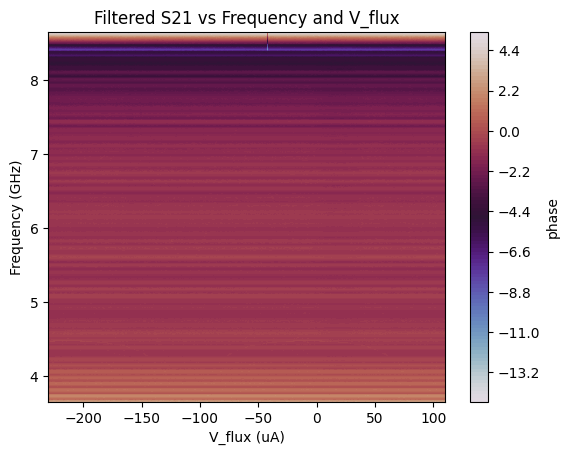

In [13]:
import numpy as np
import matplotlib.pyplot as plt

# Apply a uniform filter to calculate the local average for each point (3x3 neighborhood)
# S21_angle_avg = uniform_filter(S21_angle, size=9)


freq_grid, V_flux_grid = np.meshgrid(freq_list, V_flux_list)

# # Apply Gaussian smoothing on S21_angle
# sigma = 0.1  # Smoothing factor, adjust as needed
# S21_angle_smoothed = gaussian_filter(S21_angle, sigma=sigma)

# S21_angle_smoothed = sig.savgol_filter(S21_angle, 40, polyorder=2, axis=1)

# S21_angle_smoothed = np.abs(S21_angle_smoothed).copy()

plt.contourf(V_flux_grid, freq_grid, S21_angle, levels=100, cmap='twilight')
plt.colorbar(label='phase')
plt.ylabel('Frequency (GHz)')
plt.xlabel('V_flux (uA)')
plt.title('Filtered S21 vs Frequency and V_flux')
plt.savefig(f'Full_map_{ExpName}.png', dpi=600)
plt.show()


In [173]:

def get_peak_positions(S21_angle, V_flux_list, freq_list, V_flux_bounds=(-50, 50), freq_bounds=(4, 4.5),
                        sigma=0.1, level=0.40, deg=4, min_search=False, exclude=False, write_data=1,
                        neighborhood_size=1, frequency_threshold=6):
    global peak_positions, found_points


    S21_angle_sliced, V_flux_sliced, freq_sliced = get_sliced_data(S21_angle, V_flux_list, freq_list, V_flux_bounds=V_flux_bounds, freq_bounds=freq_bounds, return_grid = True, sigma=sigma)

    plt.contourf(V_flux_sliced, freq_sliced, S21_angle_sliced, levels=100, cmap='viridis')
    plt.colorbar(label='phase')
    plt.ylabel('Frequency (GHz)')
    plt.xlabel('V_flux (uA)')
    plt.title('Filtered S21 vs Frequency and V_flux')

    # from scipy.ndimage import uniform_filter
    # Apply a uniform filter to calculate the local average for each point (3x3 neighborhood)
    
    # S21_angle_local_avg = uniform_filter(S21_angle_sliced, size=9)
    # extreme_points_mask = S21_angle_sliced - S21_angle_local_avg > 0.01*abs(np.max(S21_angle_sliced))
    # extreme_points_mask = S21_angle_sliced > level

    # Use a maximum filter to find local maxima
    data_max = maximum_filter(S21_angle_sliced, neighborhood_size, mode='mirror')

    # Create a mask for peaks (where data is equal to its local maximum)
    extreme_points_mask = (S21_angle_sliced == data_max) & (S21_angle_sliced >= level)

    # Extract the frequency and flux values where the mask is True
    flux_data = V_flux_sliced[extreme_points_mask]
    freq_data = freq_sliced[extreme_points_mask]

    if exclude!=False:
        flux_data = np.delete(flux_data, exclude)
        freq_data = np.delete(freq_data, exclude)

# -------
    n_attempts = 0
    residuals = freq_data.copy()
    while n_attempts < 50 or np.sum(residuals) > 0.1*np.sum(np.abs(freq_data)):
        # Step 1: Perform the initial polynomial fit
        p = np.polyfit(flux_data, freq_data, deg)
        # Step 2: Use the polynomial to calculate the fitted values
        fitted_freq = np.polyval(p, flux_data)
        # Step 3: Calculate the residuals (difference between actual and fitted values)
        residuals = np.abs(freq_data - fitted_freq)
        # Step 4: Define a threshold to filter out points that are too far from the fit
        threshold = 2 * np.std(residuals)  # You can adjust this threshold value
        # Identify points that are within the threshold
        if n_attempts > 45:
            mask = (residuals < threshold)    
        else:
            mask = ((residuals < threshold) |
                    ((freq_data < frequency_threshold)& (min_search)) |
                    ((freq_data > frequency_threshold)& (not min_search)))
        # Filter the data based on the residuals
        flux_data = flux_data[mask]
        freq_data = freq_data[mask]

        # Step 5: Perform the polynomial fitting again with the filtered data
        p = np.polyfit(flux_data, freq_data, deg)

        # Generate flux points for plotting the fitted polynomial
        flux_list_plot = np.linspace(np.min(flux_data), np.max(flux_data), 1000)
        fitted_freq = np.polyval(p, flux_list_plot)

        n_attempts +=1

    print("n att", n_attempts)
# --------

    plt.plot(flux_list_plot, fitted_freq, '--', c='white')

    plt.scatter(flux_data, freq_data, color='red', label='Extreme Points', s=10)

    if min_search:
        index_of_max = np.where(fitted_freq == np.min(fitted_freq))
    else:
        index_of_max = np.where(fitted_freq == np.max(fitted_freq))
    plt.scatter(flux_list_plot[index_of_max], fitted_freq[index_of_max], marker='x',c='white', s=100)

    print('Peak position ', flux_list_plot[index_of_max], "uA", fitted_freq[index_of_max], 'GHz')

    if write_data==1:
        peak_positions.loc[-1] = [flux_list_plot[index_of_max][0], fitted_freq[index_of_max][0]]
        peak_positions.index = peak_positions.index + 1  # shifting index
        peak_positions = peak_positions.sort_index()  # sorting by index
        peak_positions = peak_positions.drop_duplicates()

        new_rows = [{columns[0]: flux_data[i], columns[1]: freq_data[i]} for i in range(freq_data.shape[0])]
        found_points = pd.concat([found_points, pd.DataFrame(new_rows)], ignore_index=True)
        found_points = found_points.drop_duplicates()


    plt.xlim(np.min(V_flux_sliced), np.max(V_flux_sliced))
    plt.ylim(np.min(freq_sliced), np.max(freq_sliced))
    plt.show()




n att 50
Peak position  [-7.95195195] uA [4.47259778] GHz


C:\Users\gusarov\AppData\Local\Temp\4\ipykernel_21904\2920402367.py:90: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  found_points = pd.concat([found_points, pd.DataFrame(new_rows)], ignore_index=True)


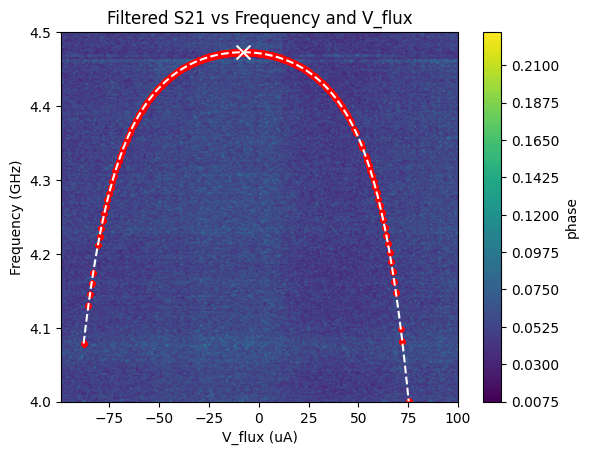

In [178]:
get_peak_positions(np.abs(S21_angle), V_flux_list, freq_list, V_flux_bounds=(-100, 100), freq_bounds=(4, 4.5), sigma=40, level=0.095, deg=8, write_data=1, frequency_threshold=4.2)

n att 50
Peak position  [200.] uA [4.47316471] GHz


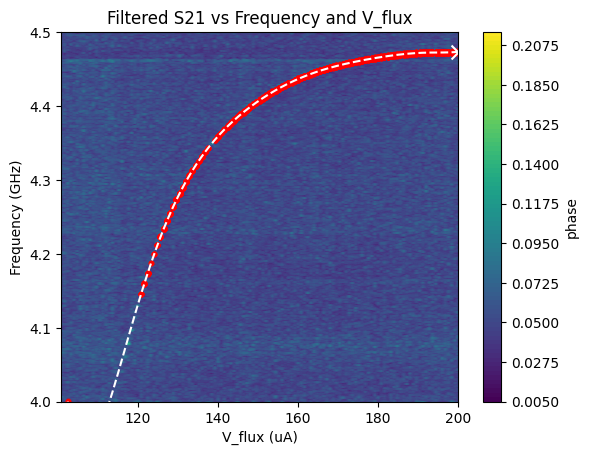

In [193]:
get_peak_positions(np.abs(S21_angle), V_flux_list, freq_list, V_flux_bounds=(100, 200), freq_bounds=(4, 4.5), sigma=40, level=0.092, deg=8, write_data=1, frequency_threshold=4.0)

n att 50
Peak position  [-200.] uA [4.46748792] GHz


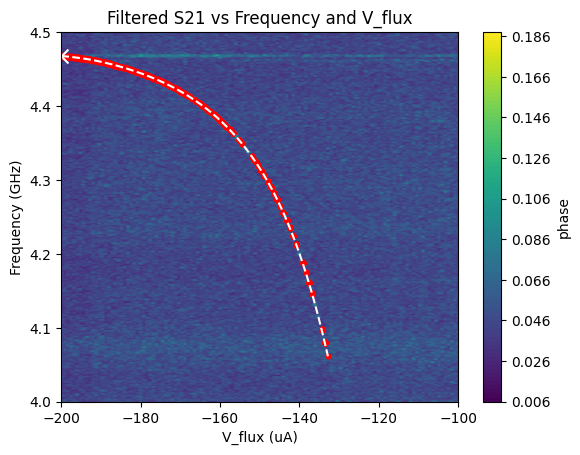

In [192]:
get_peak_positions(np.abs(S21_angle), V_flux_list, freq_list, V_flux_bounds=(-200, -100), freq_bounds=(4, 4.5), sigma=40, level=0.092, deg=8, write_data=1, frequency_threshold=4.0)

n att 50
Peak position  [94.76756757] uA [5.54523983] GHz


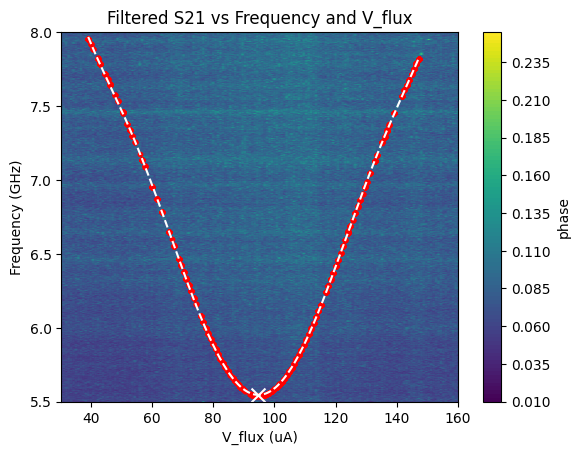

In [180]:
get_peak_positions(np.abs(S21_angle), V_flux_list, freq_list, V_flux_bounds=(30, 160), freq_bounds=(5.5, 8.0), sigma=40, level=0.12, deg=6, min_search=True,
                    write_data=1, neighborhood_size=2, frequency_threshold=6.5)

n att 50
Peak position  [-110.68748749] uA [5.54619241] GHz


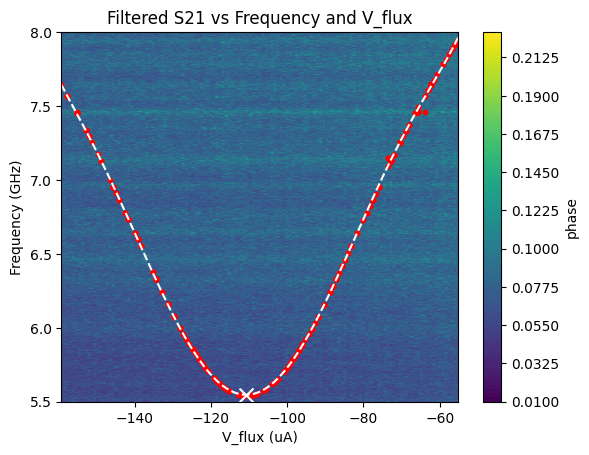

In [181]:
get_peak_positions(np.abs(S21_angle), V_flux_list, freq_list, V_flux_bounds=(-160, -55), freq_bounds=(5.5, 8), sigma=60, level=0.12, deg=6, min_search=True,
                   write_data=1, neighborhood_size=3, frequency_threshold=8.0)

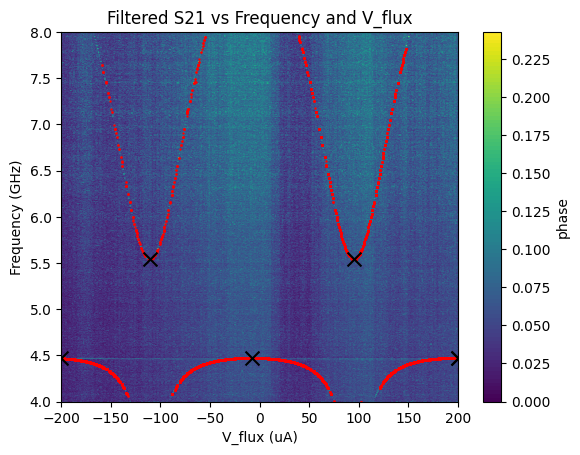

In [195]:


plt.contourf(V_flux_grid, freq_grid, S21_angle_smoothed, levels=100, cmap='viridis')
plt.colorbar(label='phase')
plt.ylabel('Frequency (GHz)')
plt.xlabel('V_flux (uA)')
plt.title('Filtered S21 vs Frequency and V_flux')

plt.scatter(found_points['V_flux'], found_points['freq'], c='red', marker='.', s=2)
plt.scatter(peak_positions['V_flux'], peak_positions['freq'], c='white', marker='x', s=100)

plt.savefig(f'Full_map_points_{ExpName}.png', dpi=600)
plt.show()

In [194]:
found_points.to_csv(f'Points_{ExpName}.csv')
peak_positions.to_csv(f'Peak_positions_{ExpName}.csv')